# What am I Investigating?
Tennis, a globally renowned sport, is a perfect blend of athleticism, strategy, and skill. Spanning from community courts to grand slam arenas, the game attracts millions of enthusiasts worldwide, both as participants and spectators. While the sport's beauty lies in its intricacies, one element stands out as a critical determinant of a player's success: the serve.  

Serving in tennis is equivalent to a pitcher's throw in baseball or a quarterback's pass in football. It sets the tone for the entire point, giving the server an initial advantage. Within this domain, the first serve is particularly crucial. A powerful and accurate first serve can drastically diminish the opponent's chances of returning the ball effectively, thereby providing the server with a strategic upper hand.  

However, it's not just about getting the ball into play. The quality of the first serve, measured by both its accuracy (percentage of successful first serves) and its effectiveness (percentage of points won on a successful first serve), can be game-changing. A higher first serve percentage indicates consistent performance, while a higher winning percentage on the first serve points reflects the serve's potency.  

This study seeks to delve deeper into these metrics to uncover patterns and insights. Specifically, I aim to answer:  
1. Is there a difference between winners' and losers' first serve percentages?
2. Does a difference exist between winners' and losers' percentages of winning first serve points?

By analyzing these questions, I hope to shed light on the pivotal role the first serve plays in a tennis match's outcome and potentially provide players and coaches with valuable insights to refine their strategies.  

---

# Data Source:
The data is taken from kaggle and is called ['Huge Tennis Database'](https://www.kaggle.com/datasets/guillemservera/tennis). This dataset is a comprehensive collection of ATP tennis rankings, match results, and player statistics. It is derived from the original database created and maintained by Jeff Sackmann, which could be found in the [following github repository](https://github.com/JeffSackmann/tennis_atp).

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, kurtosis

pd.set_option('display.max_columns', 50)

# Loading Data

Loading the datasets:

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

*On kaggle there are two methods for importing this data - by using SQLlite or by using CSV files. I chose to download the CSV files regarding all the ATP matches conducted between 1968 and 2023. Because the data of each year's matches is stored in a separate CSV file, I had to concatenate them into a variable called `combined_df`.*

Taking a glance at the dataframe:

In [3]:
combined_df.sample(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
68237,2010-560,US Open,Hard,128,G,20100830,97,104745,1.0,NaN,Rafael Nadal,L,185.0,ESP,24.2,104468,NaN,NaN,Gilles Simon,R,183.0,FRA,25.6,6-4 6-4 6-2,5,R32,119.0,6.0,3.0,76.0,43.0,39.0,19.0,14.0,1.0,1.0,6.0,2.0,98.0,54.0,35.0,23.0,14.0,5.0,9.0,1.0,10745.0,42.0,1055.0
101858,2022-2807,Gijon,Hard,32,A,20221010,292,126205,5.0,NaN,Tommy Paul,R,185.0,USA,25.3,200374,NaN,Q,Nicolas Alvarez Varona,U,NaN,ESP,21.3,6-3 7-6(3),3,R16,112.0,3.0,3.0,74.0,49.0,31.0,13.0,10.0,4.0,6.0,4.0,1.0,80.0,55.0,34.0,7.0,11.0,3.0,7.0,30.0,1375.0,231.0,230.0
20902,1996-306,St. Poelten,Clay,32,A,19960520,9,101792,6.0,NaN,Slava Dosedel,R,183.0,CZE,25.7,101649,NaN,NaN,Guillermo Perez Roldan,R,178.0,ARG,26.5,6-4 6-2,3,R32,97.0,1.0,1.0,68.0,41.0,27.0,16.0,9.0,10.0,11.0,1.0,3.0,83.0,47.0,28.0,15.0,9.0,13.0,17.0,46.0,878.0,NaN,NaN
63741,2009-414,Hamburg,Clay,48,A,20090719,5,104926,NaN,NaN,Fabio Fognini,R,178.0,ITA,22.1,104371,NaN,NaN,Ivo Minar,R,183.0,CZE,25.1,6-4 6-2,3,R64,68.0,1.0,1.0,50.0,34.0,28.0,9.0,9.0,0.0,0.0,3.0,4.0,63.0,35.0,25.0,11.0,9.0,5.0,8.0,72.0,815.0,62.0,866.0
66212,2010-407,Rotterdam,Hard,32,A,20100208,11,104997,NaN,Q,Igor Sijsling,R,190.0,NED,22.4,104999,NaN,NaN,Mischa Zverev,L,190.0,GER,22.4,6-7(2) 6-3 7-5,3,R32,113.0,7.0,1.0,105.0,76.0,57.0,13.0,17.0,2.0,4.0,7.0,2.0,96.0,56.0,45.0,18.0,16.0,2.0,6.0,245.0,191.0,92.0,549.0
94429,2019-6242,Winston-Salem,Hard,64,A,20190819,272,126094,NaN,NaN,Andrey Rublev,R,188.0,RUS,21.8,105077,9.0,NaN,Albert Ramos,L,188.0,ESP,31.5,6-7(5) 6-3 6-1,3,R32,137.0,5.0,3.0,88.0,59.0,45.0,18.0,14.0,2.0,2.0,5.0,2.0,96.0,48.0,35.0,23.0,14.0,4.0,8.0,47.0,1031.0,50.0,1019.0
34484,2000-407,Rotterdam,Hard,32,A,20000214,2,102765,NaN,NaN,Nicolas Escude,R,185.0,FRA,23.8,102184,NaN,Q,David Prinosil,R,185.0,GER,26.9,6-4 6-1,3,R32,68.0,8.0,1.0,50.0,28.0,20.0,18.0,9.0,0.0,0.0,4.0,2.0,58.0,32.0,17.0,13.0,8.0,6.0,9.0,34.0,982.0,84.0,462.0
47863,2004-418,Washington,Hard,32,A,20040816,21,103171,NaN,NaN,Raemon Sluiter,R,185.0,NED,26.3,103252,6.0,NaN,Alberto Martin,R,175.0,ESP,25.9,7-6(4) 5-7 7-6(2),3,R16,160.0,12.0,5.0,121.0,78.0,61.0,25.0,18.0,9.0,11.0,3.0,6.0,110.0,62.0,50.0,26.0,18.0,2.0,3.0,102.0,416.0,57.0,691.0
6756,1992-323,Bordeaux,Clay,32,A,19920914,28,102446,NaN,NaN,Andrei Medvedev,R,193.0,UKR,18.0,101475,2.0,NaN,Carlos Costa,R,183.0,ESP,24.3,7-6(6) 7-6(6),3,QF,133.0,3.0,2.0,93.0,56.0,38.0,19.0,12.0,5.0,8.0,3.0,5.0,99.0,56.0,33.0,24.0,12.0,4.0,7.0,33.0,813.0,12.0,1590.0
53491,2006-317,Amersfoort,Clay,32,A,20060717,5,104925,3.0,NaN,Novak Djokovic,R,188.0,SRB,19.1,104081,NaN,NaN,Boris Pashanski,R,180.0,SRB,23.7,6-0 6-3,3,R32,82.0,3.0,2.0,55.0,33.0,21.0,14.0,8.0,0.0,1.0,0.0,3.0,60.0,31.0,12.0,15.0,7.0,5.0,10.0,36.0,901.0,73.0,537.0


# Understanding the Big Picture

Getting the number of rows and columns in the dataset (pre-cleaning):

In [4]:
number_of_rows_pre_cleaning = combined_df.shape[0]
number_of_columns_pre_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_pre_cleaning} rows and {number_of_columns_pre_cleaning} columns.")

The dataset has 104682 rows and 49 columns.


---

Examining the data type of all the columns in the dataset:

In [5]:
combined_df.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size               int64
tourney_level          object
tourney_date            int64
match_num               int64
winner_id               int64
winner_seed           float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id                int64
loser_seed            float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of                 int64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms   

*After examining the data types of all the columns, I can see a problem with some of the columns. Though some of the variables are discrete, Pandas falsely attributed them to `float64`.  
In the data cleaning section I'll change the data type of those columns to the smaller data type in order to reduce memory usage.*



---



Getting the descriptive statistics of the numeric variables:

In [6]:
combined_df.describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,104682.000000,1.046820e+05,104682.000000,104682.000000,42400.000000,102228.000000,104677.000000,104682.000000,23300.000000,99827.000000,104664.000000,104682.000000,91646.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94476.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94476.000000,94475.000000,94475.000000,103493.000000,102505.000000,102146.000000,101163.000000
mean,53.518274,2.005813e+07,72.470014,106703.119075,6.923821,185.717123,25.770551,106813.711555,8.291545,185.210985,25.884222,3.441394,103.830893,6.526256,2.733728,78.128976,47.657888,35.933390,16.729124,12.409395,3.526488,5.164499,4.840857,3.484594,80.967071,48.089749,31.955067,14.983604,12.209736,4.813242,8.739995,80.657300,1429.137193,119.051084,895.639414
std,38.654709,9.444893e+04,113.061314,15824.619341,6.225644,6.661203,3.807532,16002.830220,6.735971,6.610041,3.931021,0.829437,39.529188,5.337348,2.364958,29.539587,19.242839,13.852961,6.983693,4.128099,3.086376,4.062636,4.680657,2.620083,29.471466,19.402443,14.462356,7.215126,4.136927,3.276748,4.134577,134.428663,1753.613904,179.584694,1002.257276
min,2.000000,1.990123e+07,1.000000,100284.000000,1.000000,160.000000,14.300000,100282.000000,1.000000,160.000000,14.500000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,32.000000,1.997101e+07,10.000000,102148.000000,3.000000,180.000000,23.000000,102154.000000,4.000000,180.000000,23.000000,3.000000,75.000000,3.000000,1.000000,56.000000,34.000000,26.000000,12.000000,9.000000,1.000000,2.000000,2.000000,2.000000,59.000000,34.000000,22.000000,10.000000,9.000000,2.000000,6.000000,18.000000,529.000000,37.000000,395.000000
50%,32.000000,2.005082e+07,24.000000,103602.000000,5.000000,185.000000,25.500000,103566.000000,6.000000,185.000000,25.700000,3.000000,96.000000,5.000000,2.000000,73.000000,44.000000,33.000000,16.000000,11.000000,3.000000,4.000000,4.000000,3.000000,76.000000,45.000000,30.000000,14.000000,11.000000,4.000000,8.000000,46.000000,880.000000,70.000000,658.000000
75%,64.000000,2.014022e+07,73.000000,104797.000000,8.000000,190.000000,28.300000,104919.000000,11.000000,190.000000,28.500000,3.000000,125.000000,9.000000,4.000000,94.000000,58.000000,43.000000,21.000000,15.000000,5.000000,7.000000,7.000000,5.000000,97.000000,58.000000,40.000000,19.000000,15.000000,7.000000,11.000000,89.000000,1598.000000,119.000000,1040.000000
max,128.000000,2.023083e+07,1701.000000,211468.000000,35.000000,211.000000,42.700000,212041.000000,35.000000,211.000000,46.000000,5.000000,1146.000000,113.000000,26.000000,491.000000,361.000000,292.000000,82.000000,90.000000,24.000000,34.000000,103.000000,26.000000,489.000000,328.000000,284.000000,101.000000,91.000000,28.000000,38.000000,2101.000000,16950.000000,2159.000000,16950.000000




---



Counting the number of NA's in each column:

In [7]:
combined_df.isna().sum()

tourney_id                0
tourney_name              0
surface                   0
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           62282
winner_entry          91873
winner_name               0
winner_hand               9
winner_ht              2454
winner_ioc                0
winner_age                5
loser_id                  0
loser_seed            81382
loser_entry           83599
loser_name                0
loser_hand               42
loser_ht               4855
loser_ioc                 0
loser_age                18
score                     0
best_of                   0
round                     0
minutes               13036
w_ace                 10207
w_df                  10207
w_svpt                10207
w_1stIn               10207
w_1stWon              10207
w_2ndWon              10207
w_SvGms               10206
w_bpSaved             10207
w_bpFaced           

*While examining the number of NA's in each column, my main focus is on the number of NA's in the variables depicting the match stats, because I intened the analyze them.*



---



Checking if there are any duplicate rows:

In [8]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

## Deleting Unnecessary Columns

In [9]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num", "draw_size", "winner_hand", "winner_ioc", "loser_hand", "loser_ioc"]

combined_df.drop(columns=names_of_columns_to_drop, inplace=True)

combined_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'winner_id', 'winner_name', 'winner_ht', 'winner_age',
       'loser_id', 'loser_name', 'loser_ht', 'loser_age', 'score', 'best_of',
       'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank',
       'loser_rank_points'],
      dtype='object')

*Removing unnecessary columns. Though analyzing some of them can potentially yield intresting results, I still chose to remove them and explore other variables in the data.*

## Data Formatting

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [10]:
combined_df["tourney_date"] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df["tourney_date"].head()

0   1990-12-31
1   1990-12-31
2   1990-12-31
3   1990-12-31
4   1990-12-31
Name: tourney_date, dtype: datetime64[ns]

## Feature Engineering

Dividing the 'tourney_date' column to year, month and day

In [11]:
# Year column
combined_df["Year"] = combined_df["tourney_date"].dt.strftime('%Y')

# Month column
combined_df["Month"] = combined_df["tourney_date"].dt.strftime('%m')

# Day column
combined_df["Day"] = combined_df["tourney_date"].dt.strftime('%d')

# Taking a glance at the new columns
combined_df[["Year", "Month", "Day"]].head(10)

,Year,Month,Day
0,1990,12,31
1,1990,12,31
2,1990,12,31
3,1990,12,31
4,1990,12,31
5,1990,12,31
6,1990,12,31
7,1990,12,31
8,1990,12,31
9,1990,12,31


Creating new columns:

In [12]:
# "total_points" - total points played in the match (sum of the serve points both the winner and the loser had).
combined_df["total_points"] = combined_df["w_svpt"] + combined_df["l_svpt"]

# "w_1st_serve_in_percentage" - the winners' percentage of first serve in
combined_df["w_1st_serve_in_percentage"] = combined_df["w_1stIn"]/combined_df["w_svpt"]
combined_df["w_1st_serve_in_percentage"] = round(combined_df["w_1st_serve_in_percentage"]*100, 3)

# "l_1st_serve_in_percentage" - the losers' percentage of first serve in
combined_df["l_1st_serve_in_percentage"] = combined_df["l_1stIn"]/combined_df["l_svpt"]
combined_df["l_1st_serve_in_percentage"] = round(combined_df["l_1st_serve_in_percentage"]*100, 3)

# "w_1st_serve_winning_percentage" - the winners' percentage of points won when the first serve was in
combined_df["w_1st_serve_winning_percentage"] = combined_df["w_1stWon"]/combined_df["w_1stIn"]
combined_df["w_1st_serve_winning_percentage"] = round(combined_df["w_1st_serve_winning_percentage"]*100, 3)

# "l_1st_serve_winning_percentage" - the losers' percentage of points won when the first serve was in
combined_df["l_1st_serve_winning_percentage"] = combined_df["l_1stWon"]/combined_df["l_1stIn"]
combined_df["l_1st_serve_winning_percentage"] = round(combined_df["l_1st_serve_winning_percentage"]*100, 3)

combined_df[["total_points", "w_svpt", "w_1stIn", "w_1st_serve_in_percentage", "l_svpt", "l_1stIn", "l_1st_serve_in_percentage", "w_1st_serve_winning_percentage", "l_1st_serve_winning_percentage"]].sample(10)

,total_points,w_svpt,w_1stIn,w_1st_serve_in_percentage,l_svpt,l_1stIn,l_1st_serve_in_percentage,w_1st_serve_winning_percentage,l_1st_serve_winning_percentage
63915,137.0,69.0,42.0,60.870,68.0,46.0,67.647,71.429,69.565
4716,121.0,59.0,27.0,45.763,62.0,26.0,41.935,74.074,57.692
42971,178.0,93.0,57.0,61.290,85.0,46.0,54.118,70.175,67.391
83156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28789,193.0,98.0,62.0,63.265,95.0,48.0,50.526,70.968,70.833
81743,144.0,69.0,40.0,57.971,75.0,41.0,54.667,75.000,73.171
91151,134.0,70.0,49.0,70.000,64.0,43.0,67.188,77.551,72.093
9710,181.0,77.0,50.0,64.935,104.0,67.0,64.423,86.000,62.687
19456,123.0,56.0,37.0,66.071,67.0,33.0,49.254,81.081,66.667


## Handling Missing Values

In the "Understanding The Big Picture" section I counted the number of [NA's in each column](https://colab.research.google.com/drive/1YiNo6ZBjWNuTTT72mS8qQZ_2W1ZzAFnL#scrollTo=INYVRYc3RsLx&line=1&uniqifier=1). As can be seen, we don't have the stats for 10,207 matches - 9.75% of the matches in the initial dataframe (we had information on 104,682 matches at the beginning).  
Before I decide how to handle those missing values I want to have a better understanding on them.

---



Filtering the data, keeping only the rows with NA's in the stats columns.

In [13]:
match_stats_columns_names = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced", "total_points", "w_1st_serve_in_percentage", "l_1st_serve_in_percentage", "w_1st_serve_winning_percentage", "l_1st_serve_winning_percentage"]

matches_without_stats_df = combined_df[combined_df[match_stats_columns_names].isna().any(axis=1)]

matches_without_stats_df.head(10)

,tourney_id,tourney_name,surface,tourney_level,tourney_date,winner_id,winner_name,winner_ht,winner_age,loser_id,loser_name,loser_ht,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,Year,Month,Day,total_points,w_1st_serve_in_percentage,l_1st_serve_in_percentage,w_1st_serve_winning_percentage,l_1st_serve_winning_percentage
7,1991-339,Adelaide,Hard,A,1990-12-31,101320,Magnus Gustafsson,185.0,23.9,100713,John Fitzgerald,183.0,30.0,6-2 6-3,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,188.0,NaN,1990,12,31,NaN,NaN,NaN,NaN,NaN
61,1991-354,Wellington,Hard,A,1990-12-31,101735,Richard Fromberg,196.0,20.6,101767,Lars Jonsson,188.0,20.5,6-1 6-4 6-4,5,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,100.0,NaN,1990,12,31,NaN,NaN,NaN,NaN,NaN
87,1991-301,Auckland,Hard,A,1991-01-07,100954,Luiz Mattar,183.0,27.3,101377,Christian Bergstrom,180.0,23.4,W/O,3,QF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,645.0,69.0,491.0,1991,01,07,NaN,NaN,NaN,NaN,NaN
88,1991-301,Auckland,Hard,A,1991-01-07,101120,Karel Novacek,190.0,25.7,101767,Lars Jonsson,188.0,20.5,W/O,3,QF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,759.0,84.0,432.0,1991,01,07,NaN,NaN,NaN,NaN,NaN
251,1991-D016,Davis Cup G1 QF: BRA vs PER,Hard,D,1991-02-01,100954,Luiz Mattar,183.0,27.4,101074,Carlos Di Laura,175.0,26.2,6-7(3) 6-3 6-2 6-1,5,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,691.0,NaN,NaN,1991,02,01,NaN,NaN,NaN,NaN,NaN
252,1991-D016,Davis Cup G1 QF: BRA vs PER,Hard,D,1991-02-01,101761,Jaime Oncins,196.0,20.6,101641,Jose Luis Noriega,178.0,21.3,6-3 6-2 6-2,5,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,345.0,NaN,NaN,1991,02,01,NaN,NaN,NaN,NaN,NaN
253,1991-D016,Davis Cup G1 QF: BRA vs PER,Hard,D,1991-02-01,100954,Luiz Mattar,183.0,27.4,101641,Jose Luis Noriega,178.0,21.3,6-2 6-1 7-5,5,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,691.0,NaN,NaN,1991,02,01,NaN,NaN,NaN,NaN,NaN
254,1991-D036,Davis Cup G1 QF: DEN vs MAR,Carpet,D,1991-02-01,101775,Frederik Fetterlein,190.0,20.5,102223,Karim Alami,185.0,17.6,6-4 6-3 6-1,5,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,82.0,339.0,50.0,1991,02,01,NaN,NaN,NaN,NaN,NaN
255,1991-D036,Davis Cup G1 QF: DEN vs MAR,Carpet,D,1991-02-01,101264,Michael Tauson,193.0,24.5,101962,Younes El Aynaoui,193.0,19.3,6-1 6-3 6-3,5,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.0,260.0,348.0,48.0,1991,02,01,NaN,NaN,NaN,NaN,NaN
256,1991-D036,Davis Cup G1 QF: DEN vs MAR,Carpet,D,1991-02-01,101264,Michael Tauson,193.0,24.5,102223,Karim Alami,185.0,17.6,6-3 6-4,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.0,260.0,339.0,50.0,1991,02,01,NaN,NaN,NaN,NaN,NaN


[*The Data Preprocessing*](https://colab.research.google.com/drive/1YiNo6ZBjWNuTTT72mS8qQZ_2W1ZzAFnL#scrollTo=MGAwWswN9ClG) *section is a dedicated section for creating new subset dataframes used in the analysis section. I've decided to create the dataframe in the cell above, which includes only matches we don't know their stats, in order to thoroughly examine the missing values in the original dataframe.*

Aggregating the filtered data, counting the rows with missing values by year and tourney level:

In [14]:
number_of_NA_by_year_and_tourney_level_df = matches_without_stats_df.groupby(by=["Year", "tourney_level"], as_index=False).size()
number_of_NA_by_year_and_tourney_level_df.rename(columns={"size": "number_of_NA"}, inplace=True)
number_of_NA_by_year_and_tourney_level_df

,Year,tourney_level,number_of_NA
0,1990,A,2
1,1991,A,65
2,1991,D,334
3,1991,F,1
4,1991,G,88
...,...,...,...
131,2022,M,3
132,2023,A,11
133,2023,D,96
134,2023,G,1


Plotting the number of NA's by year:

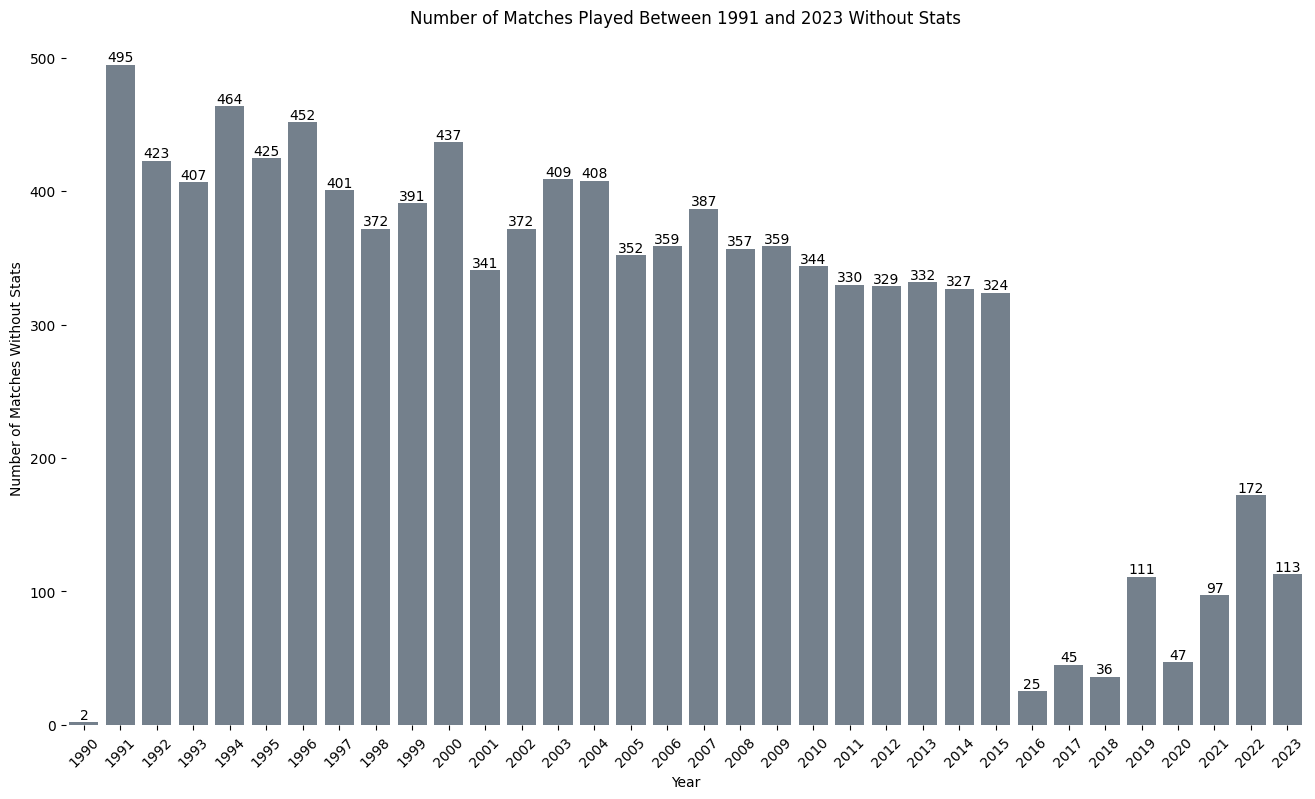

In [15]:
# Creating the plot
plt.figure(figsize=(16, 9))
NA_by_year_barplot = sns.barplot(data=number_of_NA_by_year_and_tourney_level_df, x="Year", y="number_of_NA", errorbar=None, estimator="sum", color="slategray")

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
NA_by_year_barplot.bar_label(NA_by_year_barplot.containers[0], label_type='edge')

# Rotating tick labels of the X axis
plt.xticks(rotation=45)

# Titles
NA_by_year_barplot.set_xlabel("Year")
NA_by_year_barplot.set_ylabel("Number of Matches Without Stats")
NA_by_year_barplot.set_title("Number of Matches Played Between 1991 and 2023 Without Stats")

# Showing the plot
plt.show()

Plotting the number of NA's tourney level:

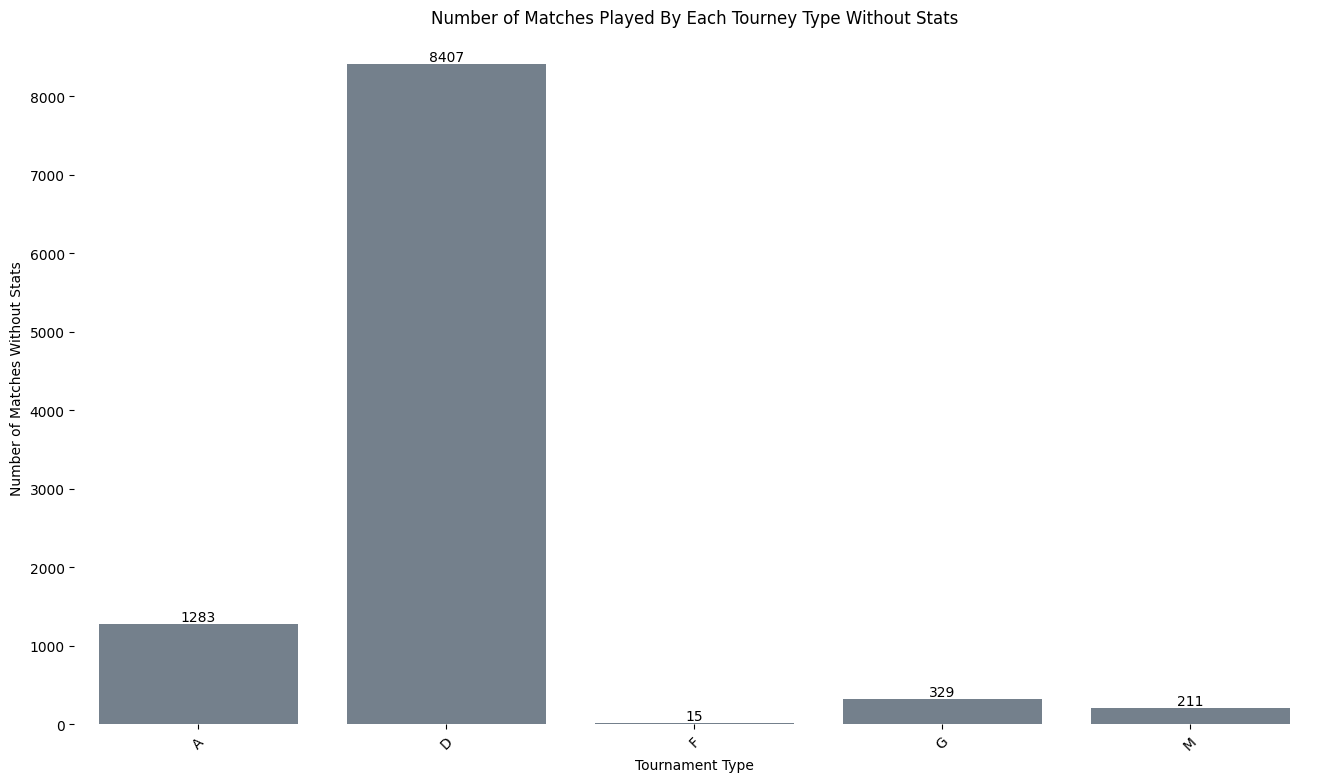

In [16]:
# Creating the plot
plt.figure(figsize=(16, 9))
NA_by_tourney_level_barplot = sns.barplot(data=number_of_NA_by_year_and_tourney_level_df, x="tourney_level", y="number_of_NA", errorbar=None, estimator="sum", color="slategray")

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
NA_by_tourney_level_barplot.bar_label(NA_by_tourney_level_barplot.containers[0], label_type='edge')

# Rotating tick labels of the X axis
plt.xticks(rotation=45)

# Titles
NA_by_tourney_level_barplot.set_xlabel("Tournament Type")
NA_by_tourney_level_barplot.set_ylabel("Number of Matches Without Stats")
NA_by_tourney_level_barplot.set_title("Number of Matches Played By Each Tourney Type Without Stats")

# Showing the plot
plt.show()

Plotting the number of NA's by both year and tourney level:

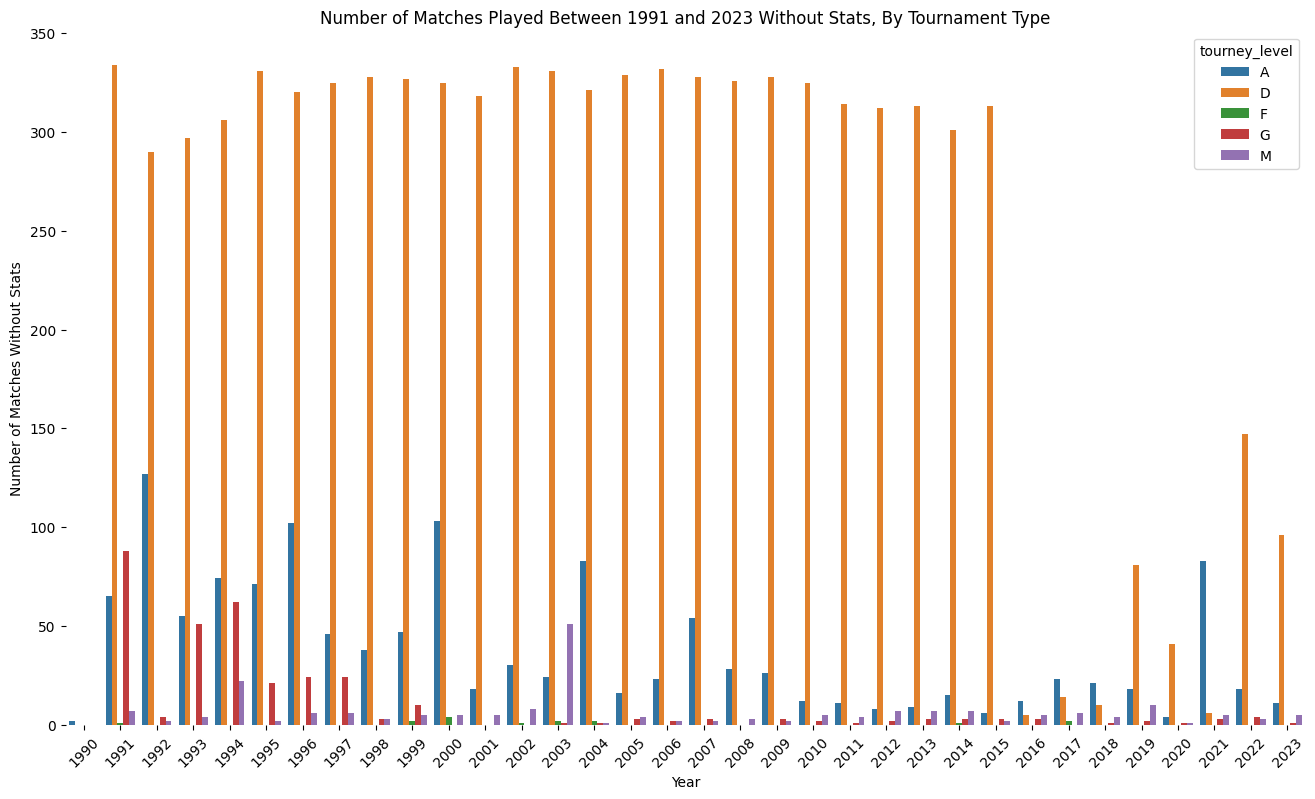

In [17]:
# Creating the plot
plt.figure(figsize=(16, 9))
NA_by_year_and_tourney_level_barplot = sns.barplot(data=number_of_NA_by_year_and_tourney_level_df, x="Year", y="number_of_NA", hue="tourney_level", estimator="sum")

# Removing the frame
sns.despine(left=True, bottom=True)

# Rotating tick labels of the X axis
plt.xticks(rotation=45)

# Titles
NA_by_year_and_tourney_level_barplot.set_xlabel("Year")
NA_by_year_and_tourney_level_barplot.set_ylabel("Number of Matches Without Stats")
NA_by_year_and_tourney_level_barplot.set_title("Number of Matches Played Between 1991 and 2023 Without Stats, By Tournament Type")

# Showing the plot
plt.show()

*From this plot it's easy to see that most of the NA's comes from matches conducted during a Davis Cup events, mainly until 2016. In this analysis I'm not going trace down why this happend, but I do believe it's an intersting topic to investigate in the future.*

Counting the number of matches per event type:

In [18]:
combined_df["tourney_level"].value_counts()

A    60153
M    17904
G    16637
D     9461
F      527
Name: tourney_level, dtype: int64

Deleting matches (rows) that we don't know their statistics:

In [19]:
combined_df.dropna(subset=match_stats_columns_names, inplace=True)

combined_df[match_stats_columns_names].isna().sum() # If the code above worked, the columns in the list above should have 0 NA's.

w_ace                             0
w_df                              0
w_svpt                            0
w_1stIn                           0
w_1stWon                          0
w_2ndWon                          0
w_SvGms                           0
w_bpSaved                         0
w_bpFaced                         0
l_ace                             0
l_df                              0
l_svpt                            0
l_1stIn                           0
l_1stWon                          0
l_2ndWon                          0
l_SvGms                           0
l_bpSaved                         0
l_bpFaced                         0
total_points                      0
w_1st_serve_in_percentage         0
l_1st_serve_in_percentage         0
w_1st_serve_winning_percentage    0
l_1st_serve_winning_percentage    0
dtype: int64

Deleting matches (rows) conducted in davis cup or tour finals and other season-ending events:

In [20]:
combined_df.drop(combined_df[(combined_df["tourney_level"] == "D") | (combined_df["tourney_level"] == "F")].index, inplace=True)

*I chose to delete rows based on two conditions: if they had NA values in the stats columns or if the matches was conducted in davis cup/tour finals and other season-ending events.*  
*I chose to do it because of the nature of those events: each type of event has unique features, making the matchs conducted during those tournaments distinguished from a typical tennis match. While I'm not 100% sure excluding those events from my analysis it the right thing to do, I think it's the better choice.*  
*From the plot that shows the number of missing values by year and event type, it seems that there alot of missing values from "A" events - which stands for other tour-level events (such as ATP 500 tournaments/ATP 250 tournaments). Because of the importance of such events, and the lack of specific type of event, I decided not to remove them.*

## Data Type Conversion

Converting all the match stats columns from float64 to int64:

In [21]:
for col in match_stats_columns_names:
    combined_df[col] = pd.to_numeric(combined_df[col], downcast='integer')

combined_df.dtypes

tourney_id                                object
tourney_name                              object
surface                                   object
tourney_level                             object
tourney_date                      datetime64[ns]
winner_id                                  int64
winner_name                               object
winner_ht                                float64
winner_age                               float64
loser_id                                   int64
loser_name                                object
loser_ht                                 float64
loser_age                                float64
score                                     object
best_of                                    int64
round                                     object
minutes                                  float64
w_ace                                       int8
w_df                                        int8
w_svpt                                     int16
w_1stIn             

Checking is the descriptive statistics of some of the variables changed after the data type conversion:

In [22]:
combined_df[match_stats_columns_names].describe()

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,total_points,w_1st_serve_in_percentage,l_1st_serve_in_percentage,w_1st_serve_winning_percentage,l_1st_serve_winning_percentage
count,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.000000,92871.00000,92871.000000,92871.000000,92871.000000,92871.000000
mean,6.515478,2.733846,78.093032,47.623919,35.901982,16.723832,12.398165,3.528852,5.167501,4.835395,3.486137,80.931238,48.048573,31.928105,14.987047,12.205145,4.811319,8.736689,159.02427,61.012371,59.120279,76.443818,65.647191
std,5.336922,2.363840,29.481801,19.209607,13.835373,6.978315,4.117422,3.084574,4.057284,4.674849,2.620162,29.379388,19.345780,14.427081,7.203001,4.122113,3.273036,4.125879,57.29506,8.602344,8.673395,8.334321,9.770657
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,6.00000,12.500000,12.500000,0.000000,0.000000
25%,3.000000,1.000000,56.000000,34.000000,26.000000,12.000000,9.000000,1.000000,2.000000,2.000000,2.000000,59.000000,34.000000,22.000000,10.000000,9.000000,2.000000,6.000000,116.00000,55.263000,53.425000,70.732000,59.551000
50%,5.000000,2.000000,73.000000,44.000000,33.000000,16.000000,11.000000,3.000000,4.000000,4.000000,3.000000,76.000000,45.000000,29.000000,14.000000,11.000000,4.000000,8.000000,148.00000,60.976000,59.130000,76.471000,66.000000
75%,9.000000,4.000000,94.000000,58.000000,43.000000,21.000000,15.000000,5.000000,7.000000,7.000000,5.000000,97.000000,58.000000,40.000000,19.000000,15.000000,7.000000,11.000000,191.00000,66.667000,64.815000,82.143000,72.308000
max,113.000000,26.000000,491.000000,361.000000,292.000000,82.000000,90.000000,24.000000,34.000000,103.000000,26.000000,489.000000,328.000000,284.000000,101.000000,91.000000,28.000000,35.000000,980.00000,100.000000,100.000000,100.000000,100.000000


## Summarizing Changes In The Data's Shape

Getting the number of rows and columns in the dataset (post-cleaning):

In [23]:
number_of_new_columns_added = 8 # Note that this doesn't automatically counts the numebr of new columns added to the DF. Update if necessary
number_of_rows_post_cleaning = combined_df.shape[0]
number_of_columns_post_cleaning = combined_df.shape[1] - number_of_new_columns_added

print(f"The dataset has {number_of_rows_post_cleaning} rows and {number_of_columns_post_cleaning+number_of_new_columns_added} columns.")
print(f"{number_of_rows_pre_cleaning-number_of_rows_post_cleaning} rows were deleted and {number_of_columns_pre_cleaning-number_of_columns_post_cleaning} columns were removed. {number_of_new_columns_added} new columns were created based on existing variabels.")

The dataset has 92871 rows and 47 columns.
11811 rows were deleted and 10 columns were removed. 8 new columns were created based on existing variabels.


# Data Preprocessing

Creating a subset used in the multivariate analysis:

In [24]:
col_names_multivariate_df = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced", "winner_ht", "winner_age", "loser_ht", "loser_age", "minutes", "total_points", "w_1st_serve_in_percentage", "l_1st_serve_in_percentage", "w_1st_serve_winning_percentage", "l_1st_serve_winning_percentage"]

multivariate_analysis_df = combined_df[col_names_multivariate_df]

multivariate_analysis_df.head()

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_ht,winner_age,loser_ht,loser_age,minutes,total_points,w_1st_serve_in_percentage,l_1st_serve_in_percentage,w_1st_serve_winning_percentage,l_1st_serve_winning_percentage
0,6,2,96,55,39,25,15,2,4,8,3,95,62,44,23,16,6,8,193.0,20.7,190.0,23.1,130.0,191,57.292,65.263,70.909,70.968
1,19,4,101,56,45,25,15,9,10,8,2,84,41,35,27,15,1,2,198.0,27.4,178.0,24.6,119.0,185,55.446,48.810,80.357,85.366
2,6,1,54,31,24,13,8,1,1,2,2,60,37,22,6,8,4,8,190.0,24.8,183.0,23.0,71.0,114,57.407,61.667,77.419,59.459
3,2,0,60,40,30,14,9,3,3,3,3,74,45,30,11,10,5,8,178.0,19.7,180.0,20.8,85.0,134,66.667,60.811,75.000,66.667
4,4,2,72,40,33,14,10,7,8,2,2,77,41,28,15,11,4,8,185.0,24.4,188.0,19.9,90.0,149,55.556,53.247,82.500,68.293


Creating a new subset for the 1st serve in percentage by surface analysis:

In [25]:
first_serve_in_melted_df = pd.melt(combined_df, id_vars =["winner_id","winner_name", "loser_id", "loser_name", "Year", "surface", "tourney_level"], value_vars=["w_1st_serve_in_percentage", "l_1st_serve_in_percentage"])
first_serve_in_melted_df.rename(columns={"variable": "winner_or_loser", "value": "first_serve_percentage"}, inplace=True)

first_serve_in_melted_df.sort_values(["winner_name", "loser_name"]).tail(10)

,winner_id,winner_name,loser_id,loser_name,Year,surface,tourney_level,winner_or_loser,first_serve_percentage
85444,200267,Zizou Bergs,105077,Albert Ramos,2020,Hard,A,w_1st_serve_in_percentage,70.130
178315,200267,Zizou Bergs,105077,Albert Ramos,2020,Hard,A,l_1st_serve_in_percentage,68.182
92337,200267,Zizou Bergs,200514,Jurij Rodionov,2023,Clay,A,w_1st_serve_in_percentage,67.521
185208,200267,Zizou Bergs,200514,Jurij Rodionov,2023,Clay,A,l_1st_serve_in_percentage,53.922
92348,200267,Zizou Bergs,111513,Laslo Djere,2023,Clay,A,w_1st_serve_in_percentage,64.103
185219,200267,Zizou Bergs,111513,Laslo Djere,2023,Clay,A,l_1st_serve_in_percentage,62.887
85506,200267,Zizou Bergs,106214,Oscar Otte,2021,Clay,A,w_1st_serve_in_percentage,69.333
178377,200267,Zizou Bergs,106214,Oscar Otte,2021,Clay,A,l_1st_serve_in_percentage,58.824
92483,200436,Zsombor Piros,106331,Christopher Oconnell,2023,Clay,A,w_1st_serve_in_percentage,63.934
185354,200436,Zsombor Piros,106331,Christopher Oconnell,2023,Clay,A,l_1st_serve_in_percentage,65.455


Creating a new subset: wins on 1st serve percentage, by surface and event type:

In [26]:
wins_on_first_serve_melted_df = pd.melt(combined_df, id_vars =["winner_id","winner_name", "loser_id", "loser_name", "Year", "surface", "tourney_level"], value_vars=["w_1st_serve_winning_percentage", "l_1st_serve_winning_percentage"])
wins_on_first_serve_melted_df.rename(columns={"variable": "winner_or_loser", "value": "first_serve_wins_percentage"}, inplace=True)

wins_on_first_serve_melted_df.sort_values(["winner_name", "loser_name"]).tail(10)

,winner_id,winner_name,loser_id,loser_name,Year,surface,tourney_level,winner_or_loser,first_serve_wins_percentage
85444,200267,Zizou Bergs,105077,Albert Ramos,2020,Hard,A,w_1st_serve_winning_percentage,61.111
178315,200267,Zizou Bergs,105077,Albert Ramos,2020,Hard,A,l_1st_serve_winning_percentage,60.000
92337,200267,Zizou Bergs,200514,Jurij Rodionov,2023,Clay,A,w_1st_serve_winning_percentage,72.152
185208,200267,Zizou Bergs,200514,Jurij Rodionov,2023,Clay,A,l_1st_serve_winning_percentage,80.000
92348,200267,Zizou Bergs,111513,Laslo Djere,2023,Clay,A,w_1st_serve_winning_percentage,78.000
185219,200267,Zizou Bergs,111513,Laslo Djere,2023,Clay,A,l_1st_serve_winning_percentage,60.656
85506,200267,Zizou Bergs,106214,Oscar Otte,2021,Clay,A,w_1st_serve_winning_percentage,75.000
178377,200267,Zizou Bergs,106214,Oscar Otte,2021,Clay,A,l_1st_serve_winning_percentage,62.500
92483,200436,Zsombor Piros,106331,Christopher Oconnell,2023,Clay,A,w_1st_serve_winning_percentage,76.923
185354,200436,Zsombor Piros,106331,Christopher Oconnell,2023,Clay,A,l_1st_serve_winning_percentage,69.444


Exporting all the dataframes to CSV files:

In [ ]:
folder_path_to_export = '/content/drive/MyDrive/Tennis_Analysis'

# Exporting the combined_df
combined_df.to_csv(path_or_buf=folder_path_to_export+"/combined_and_cleaned_df.csv")

# Exporting the first_serve_in_melted_df
first_serve_in_melted_df.to_csv(path_or_buf=folder_path_to_export+"/first_serve_in_melted_df.csv")

# Exporting the wins_on_first_serve_melted_df
wins_on_first_serve_melted_df.to_csv(path_or_buf=folder_path_to_export+"/wins_on_first_serve_melted_df.csv")

# Univariate Analysis

## Categorical Variables

### Surface Type

Counting the number of games played on each surface:

In [27]:
combined_df["surface"].value_counts()

Hard      46623
Clay      30756
Grass      9743
Carpet     5749
Name: surface, dtype: int64

Proportion of matches played on each surface:

In [28]:
combined_df["surface"].value_counts(normalize=True)

Hard      0.502019
Clay      0.331169
Grass     0.104909
Carpet    0.061903
Name: surface, dtype: float64

Plotting the number of games played on each surface type:

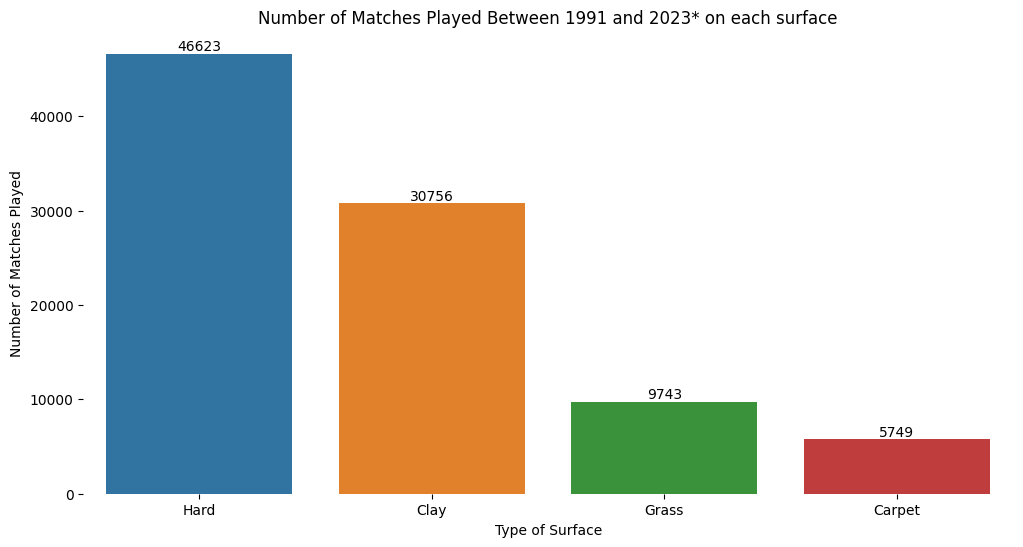

In [29]:
# Creating the plot
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')

# Titles
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")

# Showing the plot
plt.show()

### Number of Matches by Tournament Type:

Counting the number of matches in each tournament type:

In [30]:
combined_df["tourney_level"].value_counts()

A    58870
M    17693
G    16308
Name: tourney_level, dtype: int64

Proportion of tournament type:

In [31]:
combined_df["tourney_level"].value_counts(normalize=True)

A    0.633890
M    0.190512
G    0.175598
Name: tourney_level, dtype: float64

Plotting:

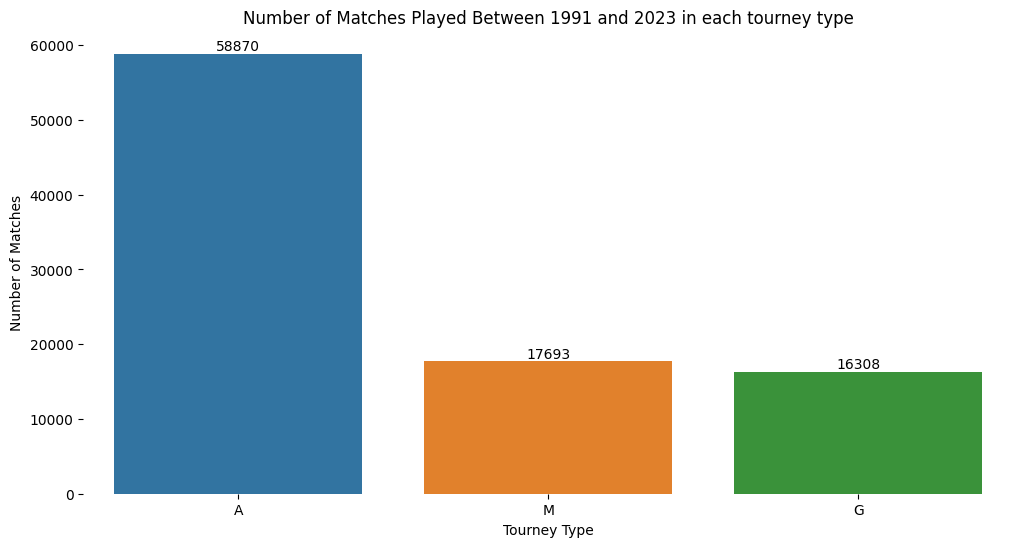

In [32]:
# Creating the plot
plt.figure(figsize=(12,6))
tourney_level_countplot = sns.countplot(data=combined_df, x="tourney_level", order=combined_df["tourney_level"].value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
tourney_level_countplot.bar_label(tourney_level_countplot.containers[0], label_type='edge')

# Titles
tourney_level_countplot.set_xlabel("Tourney Type")
tourney_level_countplot.set_ylabel("Number of Matches")
tourney_level_countplot.set_title("Number of Matches Played Between 1991 and 2023 in each tourney type")

# Showing the plot
plt.show()

## Numerical Variables

### Analyzing the total_points variable:

Descriptive statistics:

In [33]:
round(combined_df.total_points.describe(), 3)

count    92871.000
mean       159.024
std         57.295
min          6.000
25%        116.000
50%        148.000
75%        191.000
max        980.000
Name: total_points, dtype: float64

Skewness and Kurtosis:

In [34]:
total_points_skewness = combined_df.total_points.skew()
total_points_kurtosis = combined_df.total_points.kurtosis()

print(f"Skewness: {round(total_points_skewness, 3)}")
print(f"Kurtosis: {round(total_points_kurtosis, 3)}")

Skewness: 1.129
Kurtosis: 2.194


Plotting:

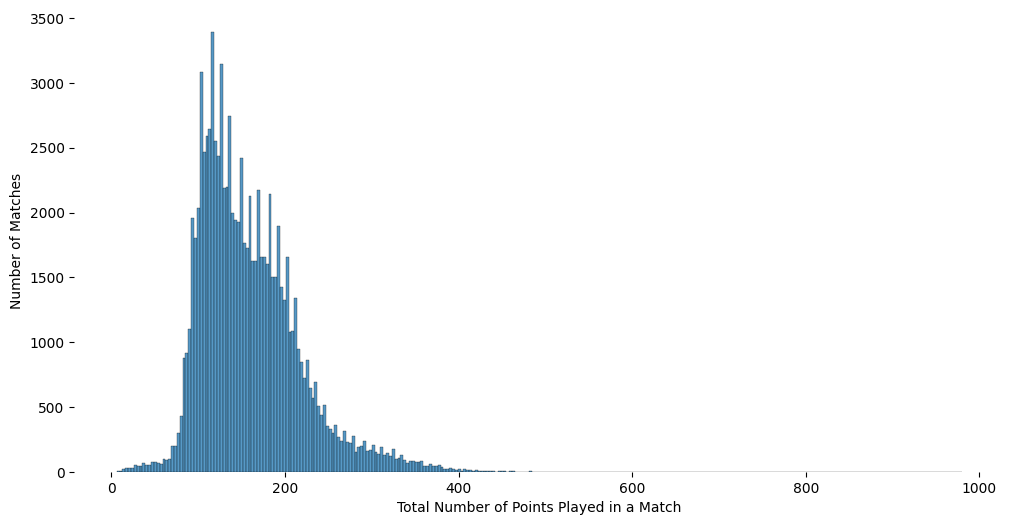

In [35]:
# Creating the plot
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")

# Showing the plot
plt.show()

### Analyzing the w_1st_serve_in_percentage variable:

Descriptive statistics:

In [36]:
combined_df["w_1st_serve_in_percentage"].describe()

count    92871.000000
mean        61.012371
std          8.602344
min         12.500000
25%         55.263000
50%         60.976000
75%         66.667000
max        100.000000
Name: w_1st_serve_in_percentage, dtype: float64

Skewness and Kurtosis:

In [37]:
w_1st_serve_in_percentage_skewness = combined_df["w_1st_serve_in_percentage"].skew()
w_1st_serve_in_percentage_kurtosis = combined_df["w_1st_serve_in_percentage"].kurtosis()

print(f"Skewness: {round(w_1st_serve_in_percentage_skewness, 3)}")
print(f"Kurtosis: {round(w_1st_serve_in_percentage_kurtosis, 3)}")

Skewness: 0.072
Kurtosis: 0.224


Plotting:

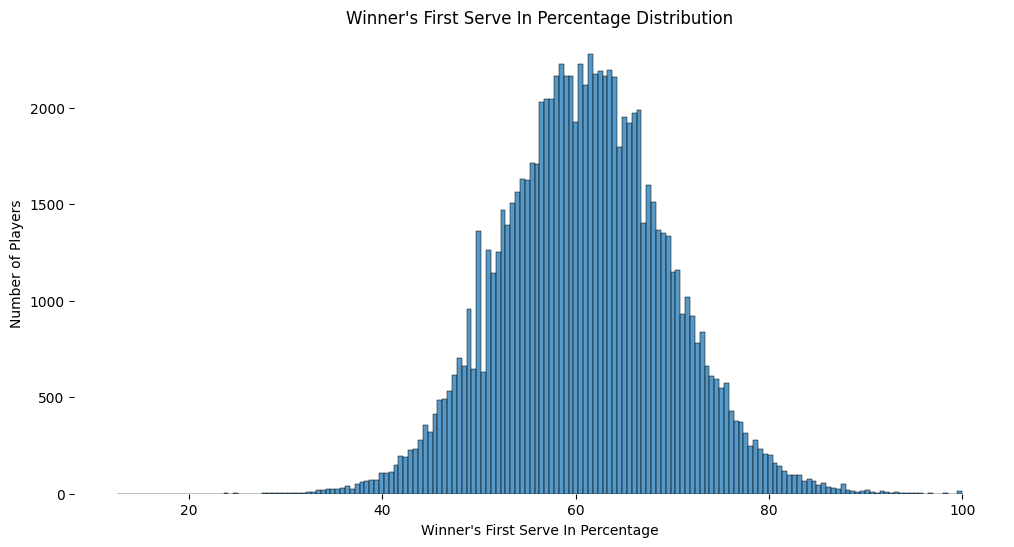

In [38]:
# Creating the plot
plt.figure(figsize=(12, 6))
w_1st_serve_in_percentage_histogram = sns.histplot(data=combined_df, x="w_1st_serve_in_percentage")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
w_1st_serve_in_percentage_histogram.set_xlabel("Winner's First Serve In Percentage")
w_1st_serve_in_percentage_histogram.set_ylabel("Number of Players")
w_1st_serve_in_percentage_histogram.set_title("Winner's First Serve In Percentage Distribution")

# Showing the plot
plt.show()

### Analyzing the l_1st_serve_in_percentage variable:

Descriptive statistics:

In [39]:
combined_df["l_1st_serve_in_percentage"].describe()

count    92871.000000
mean        59.120279
std          8.673395
min         12.500000
25%         53.425000
50%         59.130000
75%         64.815000
max        100.000000
Name: l_1st_serve_in_percentage, dtype: float64

Skewness and Kurtosis:

In [40]:
l_1st_serve_in_percentage_skewness = combined_df["l_1st_serve_in_percentage"].skew()
l_1st_serve_in_percentage_kurtosis = combined_df["l_1st_serve_in_percentage"].kurtosis()

print(f"Skewness: {round(l_1st_serve_in_percentage_skewness, 3)}")
print(f"Kurtosis: {round(l_1st_serve_in_percentage_kurtosis, 3)}")

Skewness: 0.025
Kurtosis: 0.322


Plotting:

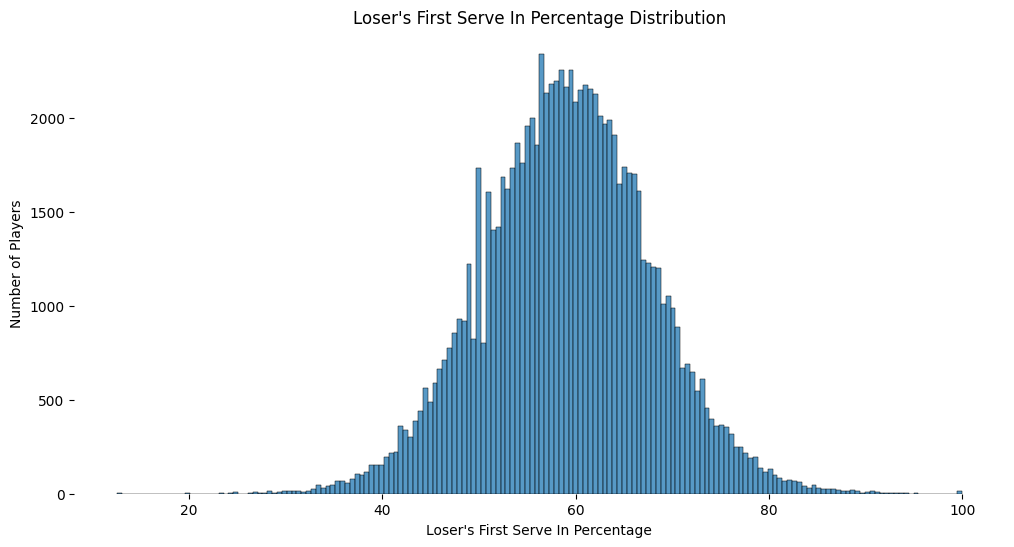

In [41]:
# Creating the plot
plt.figure(figsize=(12, 6))
l_1st_serve_in_percentage_histogram = sns.histplot(data=combined_df, x="l_1st_serve_in_percentage")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
l_1st_serve_in_percentage_histogram.set_xlabel("Loser's First Serve In Percentage")
l_1st_serve_in_percentage_histogram.set_ylabel("Number of Players")
l_1st_serve_in_percentage_histogram.set_title("Loser's First Serve In Percentage Distribution")

# Showing the plot
plt.show()

# Bivariate Analysis

## Finding trends in the numric variables:

* The goal of the pairplot visualization is to examine the relationships between all the numric variabels in the dataset. Though in many cases a correlation matrix is used to do so, I prefer to do this visualization in order to see if there's any non linear correlations between any variabels.

Creating a pairplot visualization:

In [42]:
pairplot = sns.pairplot(multivariate_analysis_df, corner=True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

* I chose to create the correlation matrix in order to check the magnitude of the linear correlation between variabels.  

Creating a correlation matrix:

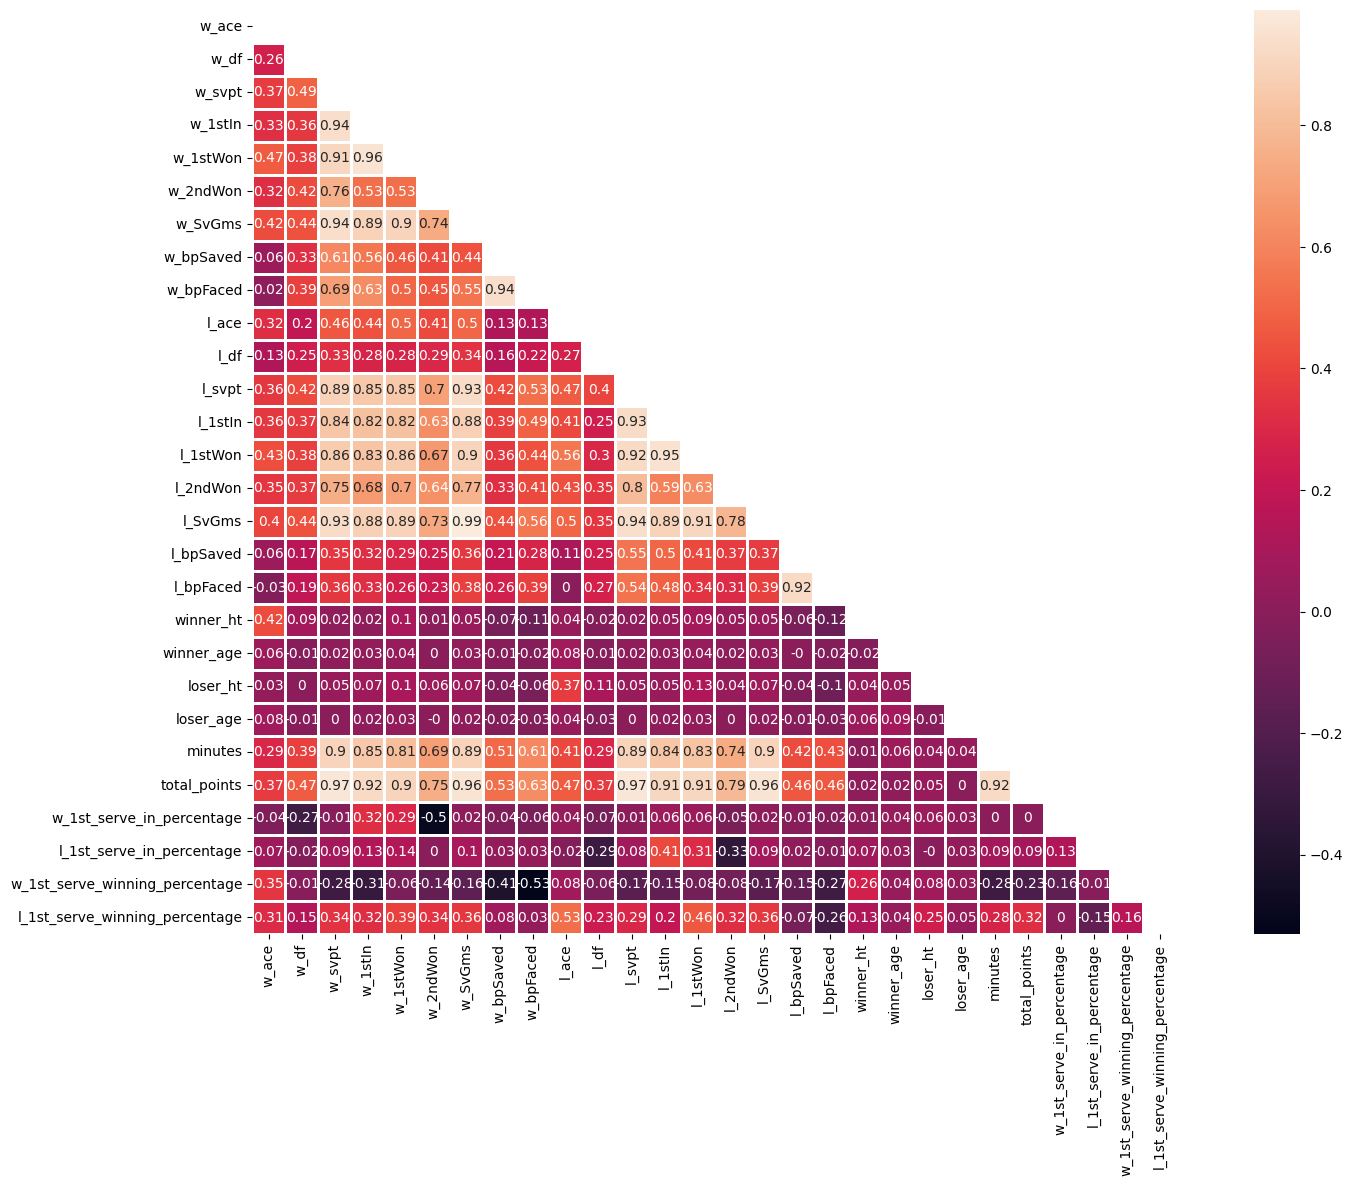

In [43]:
corr_matrix = round(multivariate_analysis_df.corr(),2)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, mask=mask, square=True, linewidths=2)
plt.show()

**Conclusions drawn from the pairplot visualization and correlation matrix:**  
* After examining the pairplot visualization, it seems that the only type of relationships are linear.
* From examining the correlation matrix, it seems that there is a strong correlation between some variabels. All of the strong correlations make sense - the correlation between the length of the match in minutes to the total number of points played in the match (*r=0.92*), for example, is easy to explain: if the match is longer, it means the players has more time to play more points.

## Comparing the average number of total points played on each surfce

Calculating the average total number of points played on each surface:

In [44]:
total_points_mean_by_surface_df = round(combined_df.groupby(["surface"], as_index=False)[["total_points"]].mean(), 2)
total_points_mean_by_surface_df.sort_values(by="total_points", ascending=False, inplace=True, ignore_index=True)
total_points_mean_by_surface_df

,surface,total_points
0,Grass,182.62
1,Hard,158.67
2,Clay,154.40
3,Carpet,146.64


Plotting the total number of points played on each surface distribution:

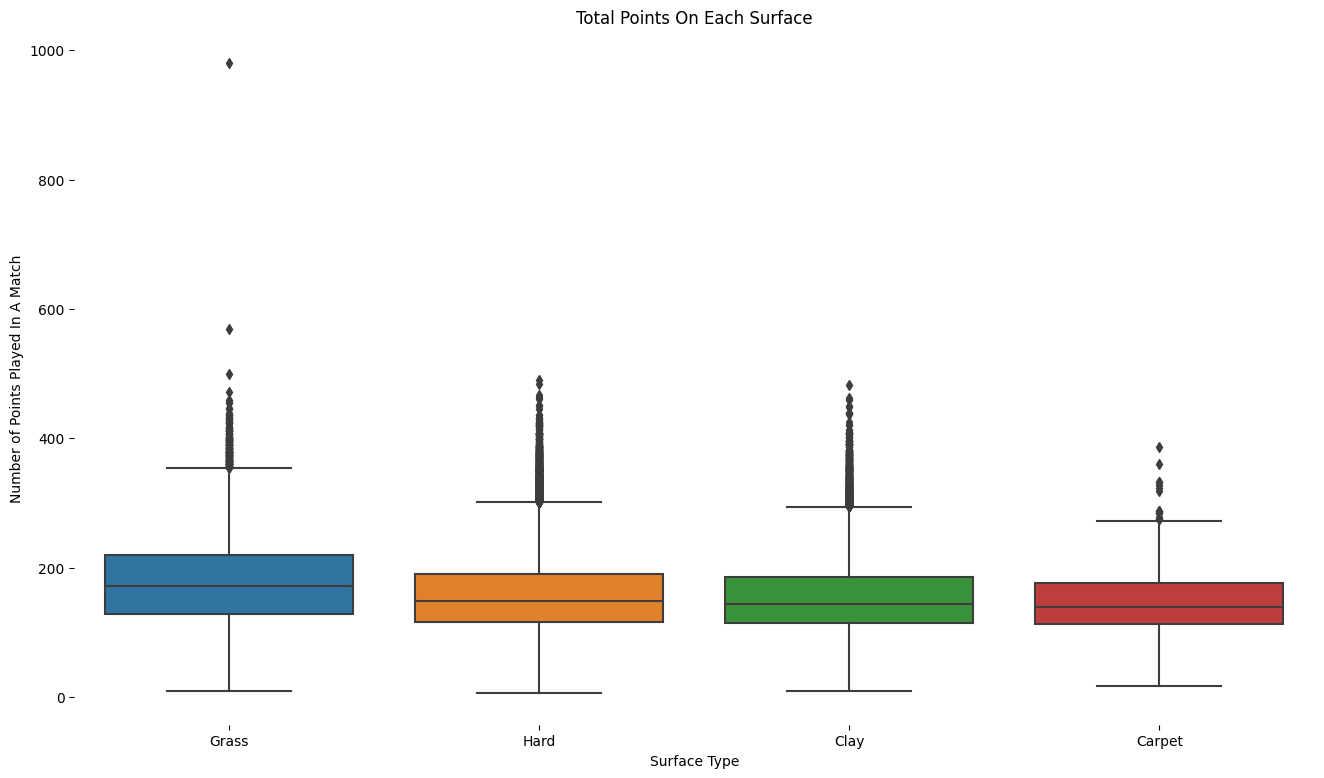

In [45]:
# Creating the plot
plt.figure(figsize=(16,9))
points_by_surface_plot = sns.boxplot(combined_df, x="surface", y="total_points", order=total_points_mean_by_surface_df["surface"])

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
points_by_surface_plot.set_xlabel("Surface Type")
points_by_surface_plot.set_ylabel("Number of Points Played In A Match")
points_by_surface_plot.set_title("Total Points On Each Surface")

# Showing the plot
plt.show()

## Comparing the average match length for each event

Calculating the average total number of points played & the average length of matches by each tourney level:

In [46]:
average_duration_by_tourney_level_df = round(combined_df.groupby(["tourney_level"], as_index=False)[["minutes", "total_points"]].mean(), 2)
average_duration_by_tourney_level_df.sort_values(by="minutes", ascending=False, inplace=True, ignore_index=True)
average_duration_by_tourney_level_df

,tourney_level,minutes,total_points
0,G,145.48,229.17
1,M,97.96,144.69
2,A,94.92,143.90


Plotting the match length on each surface distribution:

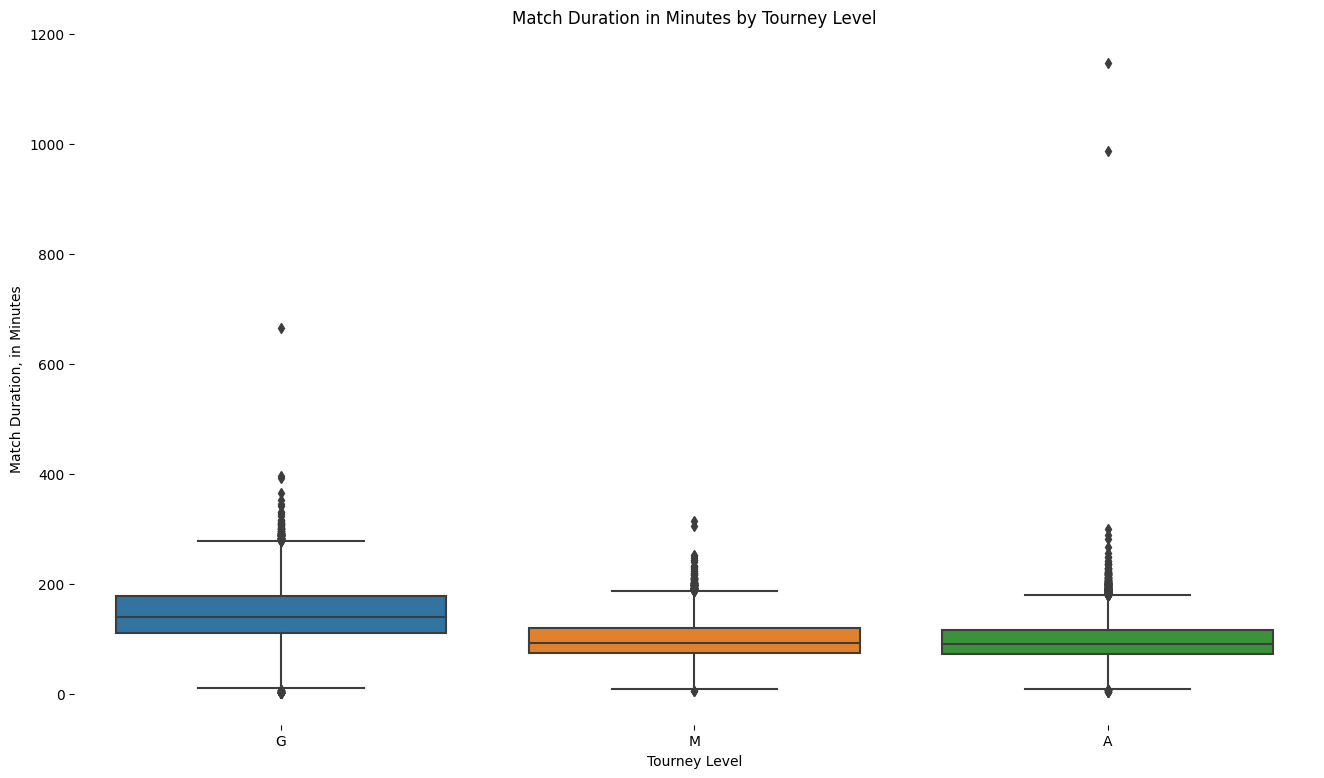

In [47]:
# Creating the plot
plt.figure(figsize=(16,9))
duration_by_tourney_level_plot = sns.boxplot(combined_df, x="tourney_level", y="minutes", order=average_duration_by_tourney_level_df["tourney_level"])

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
duration_by_tourney_level_plot.set_xlabel("Tourney Level")
duration_by_tourney_level_plot.set_ylabel("Match Duration, in Minutes")
duration_by_tourney_level_plot.set_title("Match Duration in Minutes by Tourney Level")

# Showing the plot
plt.show()

## First Serve Percentage Difference Between Winners and Losers:

Calculating the average winners' and losers' first serve percentage:

In [48]:
round(combined_df[["w_1st_serve_in_percentage", "l_1st_serve_in_percentage"]].mean(), 2)

w_1st_serve_in_percentage    61.01
l_1st_serve_in_percentage    59.12
dtype: float64

Plotting the winners' and losers' first serve percentage distribution:

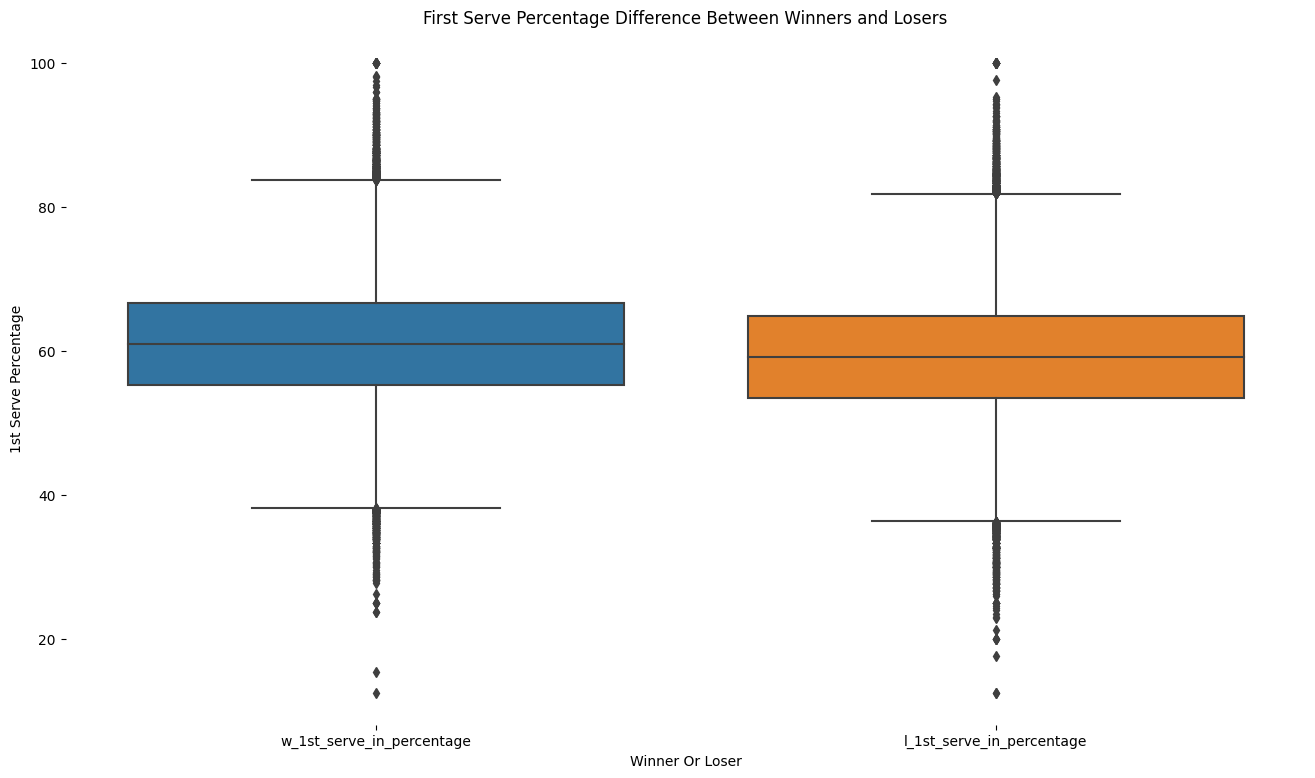

In [49]:
# Creating the plot
plt.figure(figsize=(16,9))
first_serve_percentage_winners_vs_losers_plot = sns.boxplot(data=combined_df[["w_1st_serve_in_percentage", "l_1st_serve_in_percentage"]])

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
first_serve_percentage_winners_vs_losers_plot.set_xlabel("Winner Or Loser")
first_serve_percentage_winners_vs_losers_plot.set_ylabel("1st Serve Percentage")
first_serve_percentage_winners_vs_losers_plot.set_title("First Serve Percentage Difference Between Winners and Losers")

# Showing the plot
plt.show()

## Comparing the 1st serve percentages per surface

Calculating the average and median winners' and losers' first serve percentage, per surface type:

In [50]:
first_serve_by_surface_aggregated_df = round(first_serve_in_melted_df.groupby(["surface", "winner_or_loser"], as_index=False).agg({"first_serve_percentage": ["mean", "median"]}), 2)
first_serve_by_surface_aggregated_df.sort_values(by=["surface", ("first_serve_percentage", "median")], ascending=[True, False], inplace=True, ignore_index=True)
first_serve_by_surface_aggregated_df

surface            winner_or_loser first_serve_percentage        
                                                       mean  median
0  Carpet  w_1st_serve_in_percentage                 59.092  58.974
1  Carpet  l_1st_serve_in_percentage                 57.279  57.292
2    Clay  w_1st_serve_in_percentage                 61.892  61.739
3    Clay  l_1st_serve_in_percentage                 60.003  60.000
4   Grass  w_1st_serve_in_percentage                 61.960  62.136
5   Grass  l_1st_serve_in_percentage                 60.058  60.317
6    Hard  w_1st_serve_in_percentage                 60.471  60.465
7    Hard  l_1st_serve_in_percentage                 58.569  58.654

Plotting the winners' and losers' first serve percentage per surface type distribution:

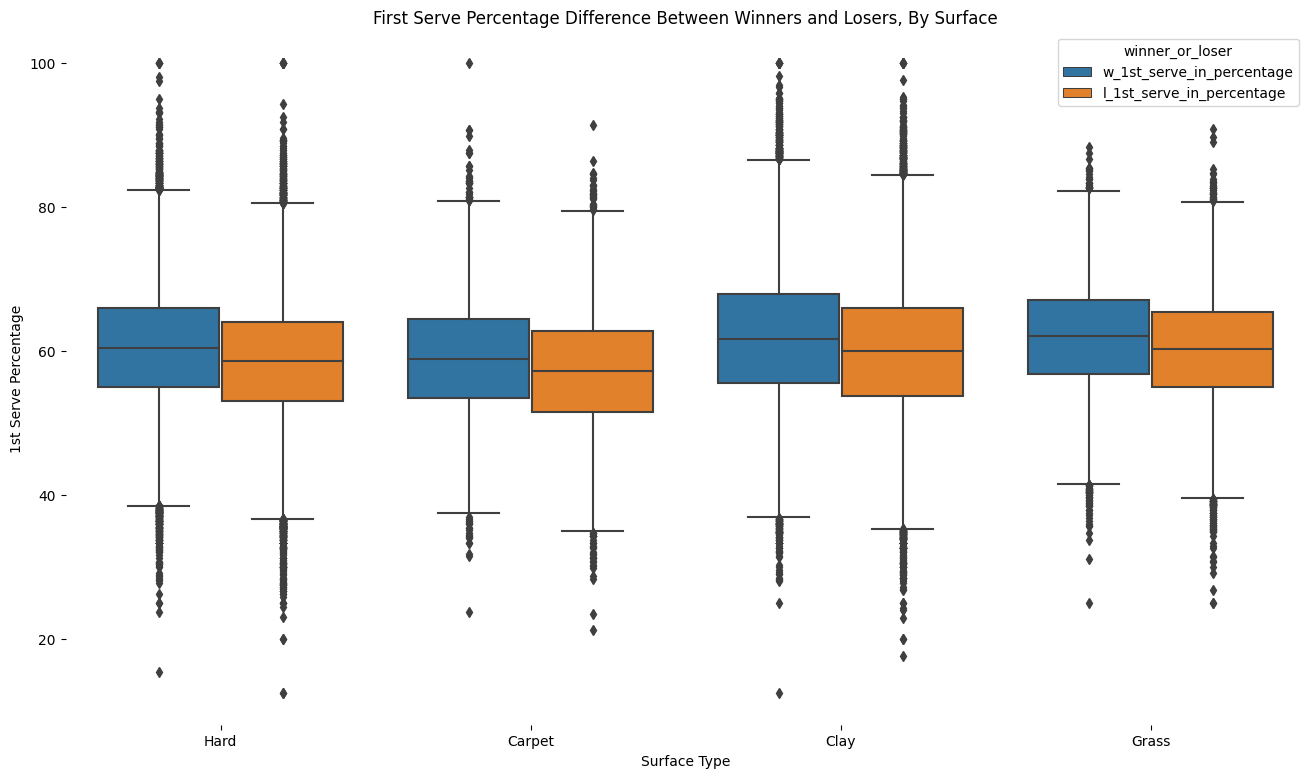

In [51]:
# Creating the plot
plt.figure(figsize=(16,9))
first_serve_percentage_by_surface_plot = sns.boxplot(data=first_serve_in_melted_df, x="surface", y="first_serve_percentage", hue="winner_or_loser")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
first_serve_percentage_by_surface_plot.set_xlabel("Surface Type")
first_serve_percentage_by_surface_plot.set_ylabel("1st Serve Percentage")
first_serve_percentage_by_surface_plot.set_title("First Serve Percentage Difference Between Winners and Losers, By Surface")

# Showing the plot
plt.show()

## Comparing the 1st serve percentages per event type

Calculating the average and median winners' and losers' first serve percentage, per tourney type:

In [52]:
first_serve_by_tourney_level_aggregated_df = round(first_serve_in_melted_df.groupby(["tourney_level", "winner_or_loser"], as_index=False).agg({"first_serve_percentage": ["mean", "median"]}), 2)
first_serve_by_tourney_level_aggregated_df.sort_values(by=["tourney_level", ("first_serve_percentage", "median")], ascending=[True, False], inplace=True, ignore_index=True)
first_serve_by_tourney_level_aggregated_df

tourney_level            winner_or_loser first_serve_percentage       
                                                             mean median
0             A  w_1st_serve_in_percentage                  60.83  60.74
1             A  l_1st_serve_in_percentage                  59.04  59.04
2             G  w_1st_serve_in_percentage                  61.96  61.98
3             G  l_1st_serve_in_percentage                  60.00  60.00
4             M  w_1st_serve_in_percentage                  60.74  60.66
5             M  l_1st_serve_in_percentage                  58.58  58.46

Plotting the winners' and losers' first serve percentage per tourney type distribution:

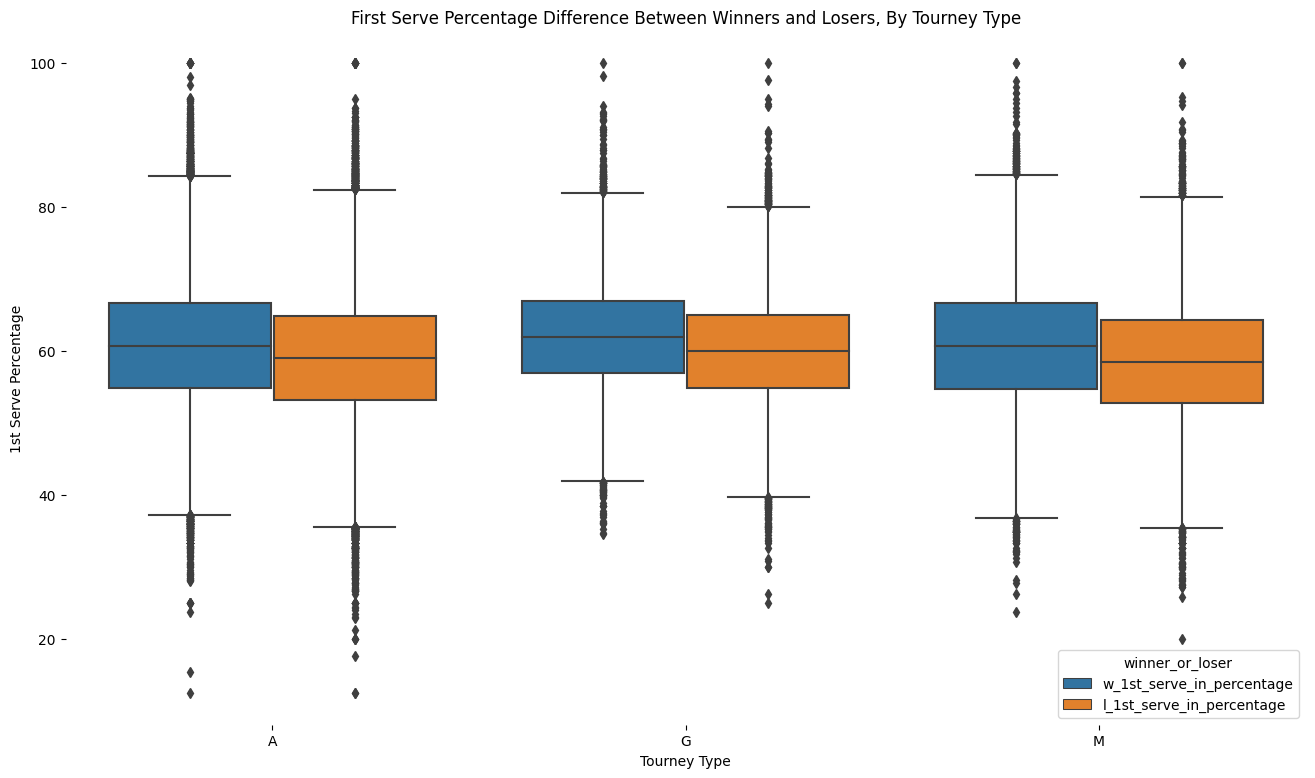

In [53]:
# Creating the plot
plt.figure(figsize=(16,9))
first_serve_percentage_by_event_type_plot = sns.boxplot(data=first_serve_in_melted_df, x="tourney_level", y="first_serve_percentage", hue="winner_or_loser")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
first_serve_percentage_by_event_type_plot.set_xlabel("Tourney Type")
first_serve_percentage_by_event_type_plot.set_ylabel("1st Serve Percentage")
first_serve_percentage_by_event_type_plot.set_title("First Serve Percentage Difference Between Winners and Losers, By Tourney Type")

# Showing the plot
plt.show()

## Comparing wins on 1st serve Difference Between Winners and Losers

Calculating the average winners' and losers' wins on first serve percentage:

In [54]:
round(combined_df[["w_1st_serve_winning_percentage", "l_1st_serve_winning_percentage"]].mean(), 2)

w_1st_serve_winning_percentage    76.44
l_1st_serve_winning_percentage    65.65
dtype: float64

Plotting the winners' and losers' wins on first serve percentage distribution:

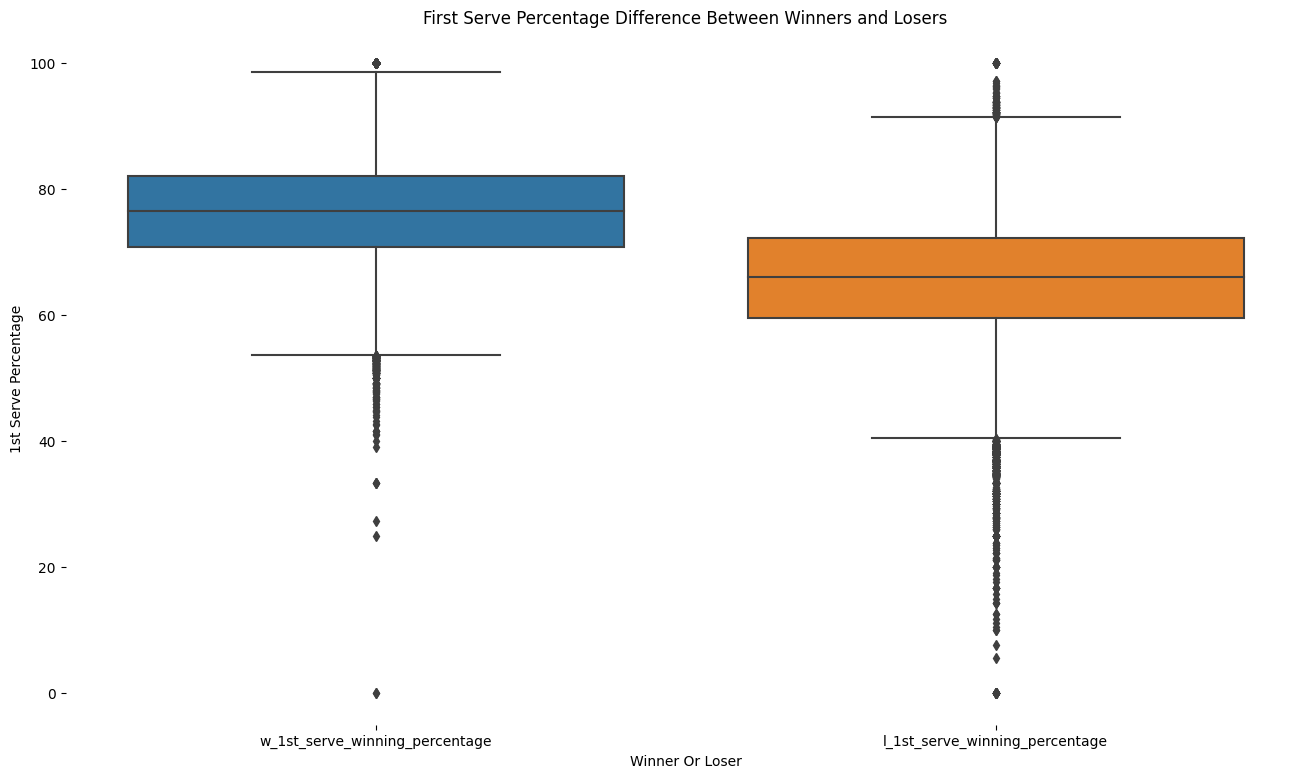

In [55]:
# Creating the plot
plt.figure(figsize=(16,9))
winning_first_serve_percentage_winners_vs_losers_plot = sns.boxplot(data=combined_df[["w_1st_serve_winning_percentage", "l_1st_serve_winning_percentage"]])

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
winning_first_serve_percentage_winners_vs_losers_plot.set_xlabel("Winner Or Loser")
winning_first_serve_percentage_winners_vs_losers_plot.set_ylabel("1st Serve Percentage")
winning_first_serve_percentage_winners_vs_losers_plot.set_title("First Serve Percentage Difference Between Winners and Losers")

# Showing the plot
plt.show()

## Comparing the winning on 1st serve percentages per surface

Calculating the average and median winners' and losers' wins on first serve percentage, per surface type:

In [56]:
winning_first_serve_by_surface_aggregated_df = round(wins_on_first_serve_melted_df.groupby(["surface", "winner_or_loser"], as_index=False).agg({"first_serve_wins_percentage": ["mean", "median"]}), 2)
winning_first_serve_by_surface_aggregated_df.sort_values(by=["surface", ("first_serve_wins_percentage", "median")], ascending=[True, False], inplace=True, ignore_index=True)
winning_first_serve_by_surface_aggregated_df

surface                 winner_or_loser first_serve_wins_percentage       
                                                                 mean median
0  Carpet  w_1st_serve_winning_percentage                       79.34  79.17
1  Carpet  l_1st_serve_winning_percentage                       68.72  69.23
2    Clay  w_1st_serve_winning_percentage                       73.53  73.33
3    Clay  l_1st_serve_winning_percentage                       62.44  62.86
4   Grass  w_1st_serve_winning_percentage                       79.27  79.31
5   Grass  l_1st_serve_winning_percentage                       69.13  69.44
6    Hard  w_1st_serve_winning_percentage                       77.42  77.42
7    Hard  l_1st_serve_winning_percentage                       66.65  67.06

Plotting the winners' and losers' wins on first serve percentage per surface type distribution:

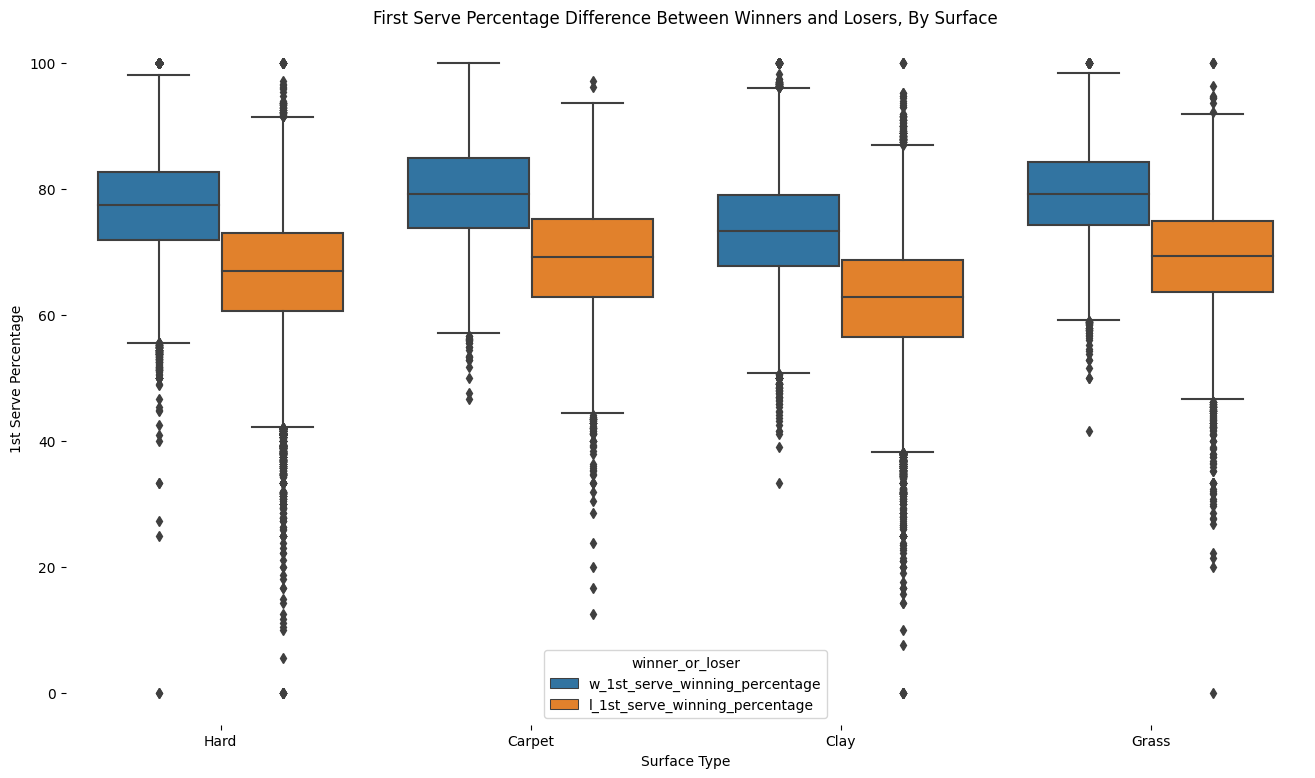

In [57]:
# Creating the plot
plt.figure(figsize=(16,9))
first_serve_percentage_by_surface_plot = sns.boxplot(data=wins_on_first_serve_melted_df, x="surface", y="first_serve_wins_percentage", hue="winner_or_loser")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
first_serve_percentage_by_surface_plot.set_xlabel("Surface Type")
first_serve_percentage_by_surface_plot.set_ylabel("1st Serve Percentage")
first_serve_percentage_by_surface_plot.set_title("First Serve Percentage Difference Between Winners and Losers, By Surface")

# Showing the plot
plt.show()

## Comparing the winning on 1st serve percentages per event type

Calculating the average and median winners' and losers' winning on first serve percentage, per tourney level:

In [60]:
winning_first_serve_by_tourney_level_aggregated_df = round(wins_on_first_serve_melted_df.groupby(["tourney_level", "winner_or_loser"], as_index=False).agg({"first_serve_wins_percentage": ["mean", "median"]}), 2)
winning_first_serve_by_tourney_level_aggregated_df.sort_values(by=["tourney_level", ("first_serve_wins_percentage", "median")], ascending=[True, False], inplace=True, ignore_index=True)
winning_first_serve_by_tourney_level_aggregated_df

tourney_level                 winner_or_loser first_serve_wins_percentage  \
                                                                       mean   
0             A  w_1st_serve_winning_percentage                       76.36   
1             A  l_1st_serve_winning_percentage                       65.48   
2             G  w_1st_serve_winning_percentage                       77.02   
3             G  l_1st_serve_winning_percentage                       66.34   
4             M  w_1st_serve_winning_percentage                       76.19   
5             M  l_1st_serve_winning_percentage                       65.57   

          
  median  
0  76.32  
1  65.85  
2  77.00  
3  66.67  
4  76.19  
5  65.96

Plotting the winners' and losers' wins on first serve percentage per tourney type distribution:

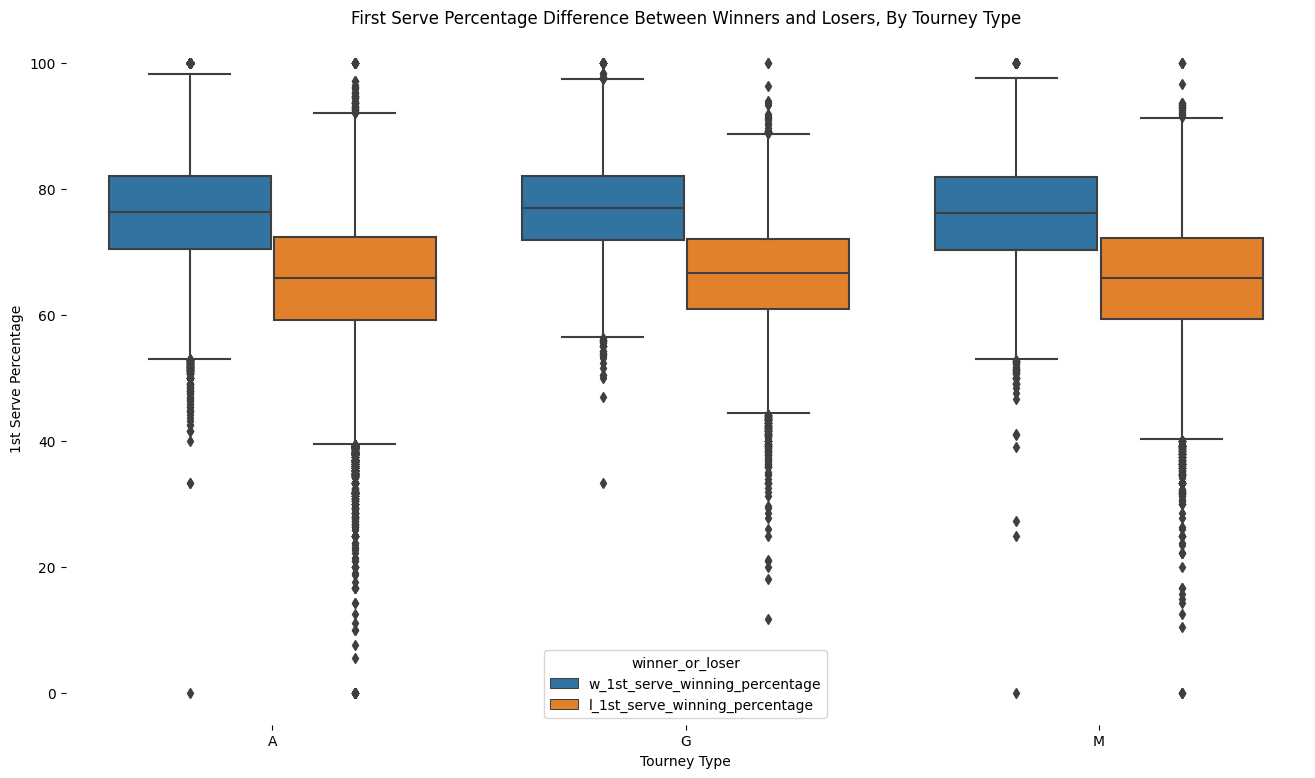

In [59]:
# Creating the plot
plt.figure(figsize=(16,9))
first_serve_percentage_by_event_type_plot = sns.boxplot(data=wins_on_first_serve_melted_df, x="tourney_level", y="first_serve_wins_percentage", hue="winner_or_loser")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
first_serve_percentage_by_event_type_plot.set_xlabel("Tourney Type")
first_serve_percentage_by_event_type_plot.set_ylabel("1st Serve Percentage")
first_serve_percentage_by_event_type_plot.set_title("First Serve Percentage Difference Between Winners and Losers, By Tourney Type")

# Showing the plot
plt.show()